# Analyse des données du challenge 25 de [datascience.net](http://www.datascience.net)

Ceci est le notebook de ma solution au challenge 25 *Le Meilleur Data Scientist de France* de [datascience.net](http://www.datascience.net), avec une [base de donnée améliorée et augmentée](https://www.data.gouv.fr/fr/datasets/base-de-donnees-publique-des-medicaments-base-officielle/) .

---

* **Modèle actuel :** ```VARIABLES = var_sub + var_num + var_admin + var_cat + var_generics```
    * Random Forest avec 200 estimators; formule du 'logprix' = log(1+log(1+log(prix)))
    * Extra Tree avec 200 estimators; même formule.

---  
* **Résultat final :** 5ème avec un score de $\sim$ 10,69601% obtenu avec le modèle Extra Tree.

---

## Importation des librairies
Commençons par importer les librairies nécessaires pour notre analyse

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import ShuffleSplit, train_test_split

Continuons en spécifiant quelques paramètres esthétiques pour les outputs.

In [2]:
np.random.seed(sum(map(ord, "aesthetics")))
sns.set_context('notebook')

#pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (15, 5)

# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 99) # permet de voir toutes les colonnes
pd.set_option('display.max_rows', 25)
pd.options.display.max_colwidth = 50

## Importation des données et visualisation
Nous allons ensuite importer les données à analyser et en visualiser les 5 premiers éléments de chaque dataset.

In [3]:
data_train = pd.read_csv('../data_challenge/master_prix_medoc.csv', encoding='utf-8', sep=';')
data_test = pd.read_csv('../data_challenge/boites_medicaments_test.csv', encoding='utf-8', sep=';')
data_train.drop(['CIS'], axis=1, inplace=True)

## Analyse descriptive
### Structure des datasets

In [4]:
print('Les données train ont ' + str(data_train.shape[0]) + ' observables, de ' + str(data_train.shape[1]) + ' variables chacune.')
print('Les données test ont ' + str(data_test.shape[0]) + ' observables, de ' + str(data_test.shape[1]) + ' variables chacune.')
print()
print('----- Data train Keys -----')
for k in data_train.keys():
    print (k)
print('----- Data test Keys -----')
for k in data_test.keys():
    print(k) 

In [5]:
# convert all strings to lowercase and remove all accents, remove spaces
for i in list(data_train.select_dtypes(include=['object'])):
    # convert all strings to lowercase and remove all accents
    data_train[i] = data_train[i].str.lower()
    data_test[i] = data_test[i].str.lower()
    # removes space if it is first character
    data_train[i] = data_train[i].apply(lambda x : x[1:] if x[0]==' ' else x)    
    data_test[i] = data_test[i].apply(lambda x : x[1:] if x[0]==' ' else x)

Il est **très** important de lire la [description des variables](https://www.datascience.net/fr/challenge/25/details#tab_brief71), afin de correctement appréhender le problème.

### Que cherchons-nous à prédire?
Nous cherchons à développer un modèle prédictif permettant d'estimer le coût d'une boîte de médicament.

Commençons donc par étudier la distribution des prix dans les données train.

### Description des données

In [6]:
data_train['prix'].value_counts()

6.36     364
18.63    333
8.14      93
23.71     86
7.55      81
1.08      79
3.94      79
7.21      74
5.27      68
3.49      65
8.13      57
5.91      48
        ... 
31.09      1
58.46      1
56.40      1
54.40      1
50.27      1
49.52      1
48.65      1
25.12      1
46.15      1
45.21      1
23.12      1
0.75       1
Name: prix, dtype: int64

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


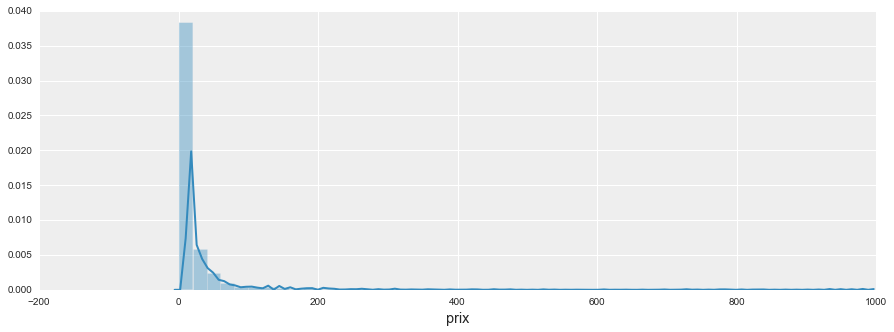

In [7]:
sns.distplot(data_train['prix'])
#print (data_train['prix'].describe())

Ce n'est pas très joli. Essayons d'améliorer les choses en prenant le logarithme des prix.

In [10]:
data_train['logprix'] = ((data_train['prix'].apply(np.log)+1).apply(np.log)+1).apply(np.log)
data_train['logprix'].value_counts()

0.716536    364
0.861754    333
0.756294     93
0.886628     86
0.744681     81
0.071523     79
0.622396     79
0.737356     74
0.682637     68
0.593817     65
0.756107     57
0.703713     48
           ... 
0.924876      1
0.903591      1
0.966695      1
0.911414      1
0.898464      1
1.090802      1
0.857481      1
0.726826      1
0.904963      1
0.992614      1
1.021307      1
0.701276      1
Name: logprix, dtype: int64

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


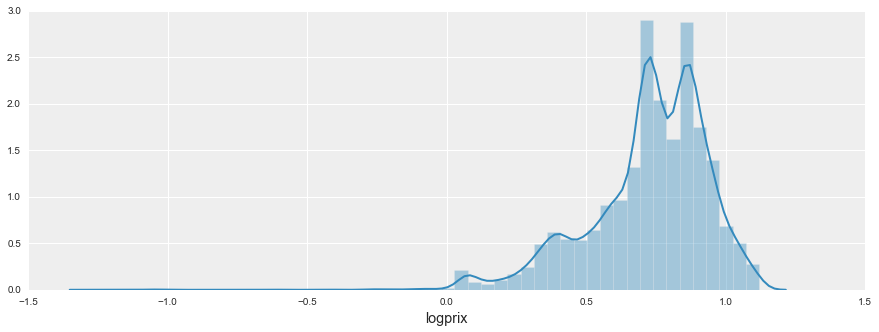

In [11]:
sns.distplot(data_train['logprix'])
#print (data_train['logprix'].describe())

C'est un peu plus joli. Nous avons une belle distribution bimodale, proche d'une gaussienne.

### Critère de performance
Le challenge utilise la métrique [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error). Celle-ci n'étant pas disponible dans sklearn, nous la codons manuellement :

In [12]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Préparation des données
### Séparation des différents types de variables
Nous constatons, en analysant les variables disponibles, qu'elles sont de quatre types différentes :
* numérique  
* catégorielle  
* date  
* texte

Nous constatons également que les taux de remboursements (qui peuvent jouer un role important sur le prix final) sont des *string* ayant un symbol $%$ à la fin. Nettoyons cette variable et convertissons la en *int*.

In [13]:
data_train['tx rembours'] = (data_train["tx rembours"]).apply(int)
data_test['tx rembours'] = (data_test["tx rembours"].str.rstrip("%")).apply(int)

In [14]:
data_train['tx rembours'].head()

0     65
1     65
2     65
3     65
4    100
Name: tx rembours, dtype: int64

### Séparations des variables à plusieurs éléments
Une autre chose que nous constatons est que les variables *voies admin*, *titulaires* et *substances* peuvent comporter plusieurs éléments séparés par une virgule. "Explosons" ces variables.

In [16]:
temp = data_train['voies admin'].apply(lambda st : st.split(','))
admins = sorted(set([l for j in temp for l in j]))
for voie in admins:
    data_train[voie] = data_train['voies admin'].apply(lambda x : 1 if voie in x else 0)
    data_test[voie] = data_test['voies admin'].apply(lambda x : 1 if voie in x else 0)

In [17]:
temp = data_train['titulaires'].apply(lambda st : st.split(','))
labos = sorted(set([l for j in temp for l in j]))
for lab in labos:
    data_train[lab] = data_train['titulaires'].apply(lambda x : 1 if lab in x else 0)
    data_test[lab] = data_test['titulaires'].apply(lambda x : 1 if lab in x else 0)

In [18]:
# Setting the GENERIQUE flag in data_train
idx = 0
for row in data_train.itertuples():
    labs = str(row[39])
    
    value_generique = 1 if ('generiques' in labs or 'generics' in labs or 'eurogenerics' in labs) else 0
    
    data_train.set_value(idx, 'generique', int(value_generique))
    
    idx += 1

In [19]:
# Setting the GENERIQUE flag in data_test
idx = 0
for row in data_test.itertuples():
    labs = str(row[40])
    
    value_generique = 1 if ('generiques' in labs or 'generics' in labs or 'eurogenerics' in labs) else 0
    
    data_test.set_value(idx, 'generique', int(value_generique))
    
    idx += 1

In [20]:
data_train['substances'].head()

0                               desogestrel
1    montelukast acide, montelukast sodique
2                 chlorhydrate de diltiazem
3     acide valproique, valproate de sodium
4                                 letrozole
Name: substances, dtype: object

In [21]:
temp = data_train['substances'].apply(lambda st : st.split(','))
data_train['nb_sub'] = data_train['substances'].apply(lambda st : len(st.split(',')))
data_test['nb_sub'] = data_test['substances'].apply(lambda st : len(st.split(',')))
#data_train['nb_sub'] = ((data_train['nb_sub'].apply(np.log)+1).apply(np.log)+1).apply(np.log)
#data_test['nb_sub'] = ((data_test['nb_sub'].apply(np.log)+1).apply(np.log)+1).apply(np.log)
subs = set([l for j in temp for l in j])
subs = {x[1:] if x[0]==' ' else x for x in subs}
subs = {x[:-1] if x[-1] == ' ' else x for x in subs}
subs = sorted(subs)
for s in subs:
    data_train[s] = data_train['substances'].apply(lambda x : 1 if s in x else 0)
    data_test[s] = data_test['substances'].apply(lambda x : 1 if s in x else 0)

In [22]:
# variables numériques
var_lib = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule']
var_nb = ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']
var_num = var_lib + var_nb+ ['tx rembours']
# variables catégorielles
var_cat = ['statut', 'etat commerc', 'agrement col',
          'statut admin', 'type proc', 'forme pharma']
# variables dates
var_dates = ['date declar annee', 'date amm annee']

# variable texte
var_txt = ['libelle', 'titulaires', 'substances']

var_admin = list(admins) # voies admin
var_lab = list(labos) # titulaires
var_sub = list(subs)+['nb_sub'] # substances

var_generics = ['generique']

### Encodage des variables catégorielles
Nous avons besoin de transformer les variables catégorielles en nombre, afin de pouvoir les utiliser dans les algorithmes de machine learning (qui nécessitent des nombres comme paramètres d'entrée).

Pour cela, nous allons utiliser la fonction [*LabelEncoder()*](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [23]:
data_train[var_cat].head()

,statut,etat commerc,agrement col,statut admin,type proc,forme pharma
0,presentation active,declaration de commercialisation,oui,autorisation active,procedure decentralisee,comprime pellicule
1,presentation active,declaration de commercialisation,oui,autorisation active,procedure de reconnaissance mutuelle,comprime a croquer
2,presentation active,declaration de commercialisation,oui,autorisation active,procedure nationale,gelule a liberation prolongee
3,presentation active,declaration de commercialisation,oui,autorisation active,procedure nationale,granules a liberation prolongee
4,presentation active,declaration d'arret de commercialisation,non,autorisation active,procedure nationale,comprime pellicule


In [24]:
for c in var_cat:
    le = LabelEncoder()
    le.fit(data_train[c].append(data_test[c]))
    data_train[c] = le.transform(data_train[c])
    data_test[c] = le.transform(data_test[c])

In [25]:
data_train[var_cat].head(5)

,statut,etat commerc,agrement col,statut admin,type proc,forme pharma
0,1,2,1,1,3,45
1,1,2,1,1,2,9
2,1,2,1,1,4,81
3,1,2,1,1,4,86
4,1,1,0,1,4,45


## Création du modèle prédictif
Nous sommes maintenant prêt à définir un modèle prédictif des prix des médicaments.

Nous allons utiliser un modèle *Random Forest Regression*

Nous allons également utiliser toutes les variables à notre disposition, excepté les variables textuelles.

Enfin, afin d'éviter le [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) et correctement estimer les performances de nos modèles, nous allons utiliser la [validation croisée](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) avec le critère *k-fold*.

## Random Forest Regression

In [ ]:
NBROUND = 5
#VARIABLES = var_sub + var_num + var_admin + var_cat + var_dates
VARIABLES = var_sub + var_num + var_admin + var_generics + var_cat
# Random Forest Model
params = {'n_estimators': 10, 'n_jobs':-1}
err = 0
for train_index, test_index in KFold(n_splits=NBROUND).split(data_train):
    y = data_train['logprix']
    X = data_train[VARIABLES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(-1+np.exp(-1+np.exp(y_test))), np.exp(-1+np.exp(-1+np.exp(pred))))
    #err += mape_error(np.exp(y_test), np.exp(pred))
    #print (mape_error(np.exp(y_test), np.exp(pred)))
print ("*** Random Forest MAPE Error : ", err / NBROUND)

## Prédictions
Nous allons entrainer le modèle sur un ensemble de variables sélectionnées qui semblent optimiser le score de prédiction

In [26]:
rf = RandomForestRegressor(n_estimators = 200, n_jobs=-1)
VARIABLES = var_sub + var_num + var_admin + var_cat + var_generics
rf.fit(data_train[VARIABLES], data_train['logprix'])
predictions = np.exp(-1+np.exp(-1+np.exp(rf.predict(data_test[VARIABLES]))))

In [28]:
cols = data_train.columns.tolist()
#print(cols)

['libelle', 'libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 'libelle_tube', 'libelle_stylo', 'libelle_seringue', 'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 'libelle_gelule', 'libelle_film', 'libelle_poche', 'libelle_capsule', 'nb_plaquette', 'nb_ampoule', 'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue', 'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml', 'statut', 'etat commerc', 'agrement col', 'tx rembours', 'forme pharma', 'voies admin', 'statut admin', 'date declar annee', 'date amm annee', 'type proc', 'titulaires', 'substances', 'prix', 'logprix', 'auriculaire', 'buccogingivale', 'cutanee', 'dentaire', 'endocanalaire', 'endosinusale', 'gastrique', 'gastro-enterale', 'gingivale', 'infiltration', 'inhalee', 'intra cholangio-pancreatique', 'intra-arterielle', 'intra-articulaire', 'intra-murale', 'intra-uterine', 'intracaverneuse', 'intradermique', 'intradurale', 'intralesionnelle', 'intramusculaire', 'intra

In [30]:
names = ['libelle', 'libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 'libelle_tube', 'libelle_stylo', 'libelle_seringue', 'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 'libelle_gelule', 'libelle_film', 'libelle_poche', 'libelle_capsule', 'nb_plaquette', 'nb_ampoule', 'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue', 'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml', 'statut', 'etat commerc', 'agrement col', 'tx rembours', 'forme pharma', 'voies admin', 'statut admin', 'date declar annee', 'date amm annee', 'type proc', 'titulaires', 'substances', 'auriculaire', 'buccogingivale', 'cutanee', 'dentaire', 'endocanalaire', 'endosinusale', 'gastrique', 'gastro-enterale', 'gingivale', 'infiltration', 'inhalee', 'intra cholangio-pancreatique', 'intra-arterielle', 'intra-articulaire', 'intra-murale', 'intra-uterine', 'intracaverneuse', 'intradermique', 'intradurale', 'intralesionnelle', 'intramusculaire', 'intraperitoneale', 'intrasereuse', 'intrathecale', 'intraveineuse', 'intraventriculaire cerebrale', 'intravesicale', 'intravitreenne', 'nasale', 'ophtalmique', 'orale', 'periarticulaire', 'peridurale', 'perineurale', 'perioculaire', 'rectale', 'sous-cutanee', 'sublinguale', 'transdermique', 'vaginale', 'voie buccale autre', 'voie extracorporelle autre', 'voie parenterale autre', 'abbott products', 'abbvie (royaume-uni)', 'abdi farma (portugal)', 'accord healthcare (royaume uni)', 'accord healthcare france', 'acino pharma (allemagne)', 'acraf', 'actavis france', 'actavis group (islande)', 'actavis group ptc (islande)', 'addmedica', 'advicenne', 'aerocid', 'agfa healthcare imaging agents (allemagne)', 'aguettant', 'alcon', 'alcon laboratories (royaume-uni)', 'alfa wassermann pharma', 'alk abello (danemark)', 'alkopharma (luxembourg)', 'allergan france', 'allergan pharmaceuticals ireland (irlande)', 'alliance pharmaceuticals (royaume-uni)', 'almirall', 'almirall (espagne)', 'ambapharm', 'amdipharm', 'amgen europe', 'aptalis pharma', 'archimedes development (royaume-uni)', 'arkopharma', 'arrow (danemark)', 'arrow generiques', 'aspen pharma trading (irlande)', 'assistance publique - hopitaux de paris - ap-hp', 'astellas pharma', 'astellas pharma europe (pays-bas)', 'astrazeneca', 'astrazeneca ab', 'atnahs pharma uk (royaume-uni)', 'aventis pharma', 'b braun medical', 'b braun melsungen', 'baxter', 'bayer healthcare', 'bayer pharma (allemagne)', 'bb farma (italie)', 'besins healthcare (belgique)', 'besins international (france)', 'bial - portela & ca (portugal)', 'biocodex', 'biocodex benelux (belgique)', 'biogaran', 'biogen idec limited (royaume-uni)', 'bioluz', 'bioprojet', 'bioprojet europe (irlande)', 'bluefish pharmaceuticals (suede)', 'boehringer ingelheim france', 'boehringer ingelheim international', 'bouchara-recordati', 'bracco imaging france', 'bracco international', 'bristol myers squibb', 'bristol myers squibb pharma (grande bretagne)', 'bristol-myers squibb / pfizer eeig (royaume-uni)', 'bristol-myers squibb and gilead sciences (irlande)', 'chaix et du marais', 'chemi (italie)', 'chemineau', 'cheplapharm arzneimittel (allemagne)', 'chiesi', 'chiesi farmaceutici', 'chugai pharma france', 'cilfa developpement', 'cls pharma', 'codexial dermatologie', 'cooper', 'crinex', 'cristers', 'csl behring (allemagne)', 'daiichi sankyo europe (allemagne)', 'daiichi sankyo france', 'daleco pharma (pays-bas)', 'db pharma', 'dema consult (republique tcheque)', 'desma pharma', 'dexo', 'distriquimica', "dr. reddy's laboratories (uk) (royaume-uni)", 'ducray', 'effik', 'eg labo - laboratoires eurogenerics', 'eisai (royaume-uni)', 'eisai sa', 'elerte', 'eli lilly (pays bas)', 'endo ventures (irlande)', 'erempharma', 'erempharma (societe)', 'ethypharm', 'eumedica', 'europhta', 'eusa pharma (france)', 'eusa pharma (royaume-uni)', 'evolupharm', 'exod', 'expanscience', 'ferrer internacional (espagne)', 'ferring (france)', 'ferring pharmaceuticals (danemark)', 'finox biotech (liechtenstein)', 'flexpharma', 'forest laboratories uk limited (royaume-uni)', 'fresenius kabi france', 'fresenius medical care deutschland', 'fresenius medical care nephrologica deutschland', 'galderma international', 'galien luxembourg (luxembourg)', 'ge healthcare', 'gedeon richter', 'gekofar (italie)', 'generics', 'genevrier', 'genzyme europe', 'gifrer barbezat', 'gilead sciences international (royaume-uni)', 'glaxo group (royaume-uni)', 'glaxosmithkline', 'glaxosmithkline biologicals', 'goapharma', 'granions', 'grimberg', 'guerbet', 'h2 pharma', 'h3 (hcube) sante', 'hcs (belgique)', 'horus pharma', 'hospira france', 'hospira uk (royaume-uni)', 'hra pharma', 'idl international drug licensing', 'imaxio', 'infai & nmr imaging (allemagne)', 'innotech international', 'intas pharmaceuticals', 'inter trade pharma (royaume uni)', 'ionfarma (espagne)', 'ipsen pharma', 'iroko products limited (royaume-uni)', 'j uriach & cia sa', 'janssen biologics (pays-bas)', 'janssen cilag', 'janssen cilag international nv', 'johnson & johnson sante beaute france', 'jolly jatel', 'keocyt', 'kreussler & co allemagne', 'krka (slovenie)', 'labcatal', 'laboratoire bailly creat', 'laboratoire biodim', 'laboratoire ccd', 'laboratoire chauvin', 'laboratoire renaudin', 'laboratoire sfdb', 'laboratoire unither', 'laboratoires alter', 'laboratoires bailleul (luxmebourg)', 'laboratoires bailleul portugal (portugal)', 'laboratoires doliage', 'laboratoires gerda', 'laboratoires grunenthal', 'laboratoires iprad pharma', 'laboratoires juvise pharmaceuticals', 'laboratoires lavipharm', 'laboratoires leo', 'laboratoires madaus', 'laboratoires majorelle', 'laboratoires mayoly spindler', 'laboratoires neitum', 'laboratoires nepenthes', 'laboratoires ursapharm', 'laboratorios velvian (espagne)', 'laphal', 'leo pharma a/s (danemark)', 'les laboratoires servier', 'leurquin mediolanum', 'liconsa', 'lilly france', 'lisapharm', 'lundbeck (danemark)', 'lundbeck sas', 'maco pharma', 'majorelle luxembourg soparfi (luxembourg)', 'mallinckrodt deutschland (allemagne)', 'meda (suede)', 'meda pharma (france)', 'medac (allemagne)', 'medac gesellschaft fur klinische spezialpraparate (allemagne)', 'medi-farma', 'medice', 'medicom healthcare (royaume-uni)', 'medimpex (angleterre)', 'medipha sante', 'mediwin', 'menarini france', 'menarini international operations luxembourg', 'merck sante', 'merck serono europe (royaume-uni)', 'merck sharp & dohme (grande bretagne)', 'merck sharp & dohme (pays-bas)', 'mithridatum', 'molteni & alitti', 'msd france', 'mundipharma', 'mylan medical', 'mylan sas', 'nelsonius', 'nepalm', 'nexmed pharma', 'nordic pharma', 'norgine (pays-bas)', 'norgine pharma', 'nova laboratories (royaume-uni)', 'novartis europharm (royaume-uni)', 'novartis pharma', 'novartis sante familiale', 'novartis vaccines and diagnostics (italie)', 'novo nordisk', 'novo nordisk (danemark)', 'nuron biotech (pays-bas)', 'nycomed france', 'opening pharma france', 'orion corporation', 'otsuka pharmaceutical europe (royaume-uni)', 'panmedica', 'panpharma', 'paucourt', 'pfizer (grande bretagne)', 'pfizer holding france', 'pfizer sante familiale', 'pharma developpement', 'pharma lab', 'pharmaki generics (royaume-uni)', 'pharmastra', 'pharmaswiss ceska republika (republique tcheque)', 'pharmathen', 'pharmy ii', 'phoenix labs (irlande)', 'pierre fabre dermatologie', 'pierre fabre medicament', 'plus pharmacie', 'primius lab (royaume-uni)', 'probionov', 'procter & gamble pharmaceuticals france', 'prostrakan (royaume uni)', 'prostrakan pharma', 'qualimed (lyon)', 'ranbaxy pharmacie generiques', 'ratiopharm (allemagne)', 'rb pharmaceuticals (royaume-uni)', 'reckitt benckiser healthcare (uk) (royaume-uni)', 'reckitt benckiser healthcare france', 'recordati ireland', 'riemser pharma (allemagne)', 'roche', 'roche registration', 'rottapharm', 'rph pharmaceuticals (suede)', 'saint germain', 'sandoz', 'sandoz (autriche)', 'sanofi aventis (allemagne)', 'sanofi aventis france', 'sanofi clir', 'sanofi pasteur', 'sanofi pasteur msd', 'sanofi-aventis groupe', 'schering plough europe', 'sciencex', 'serb', 'serb (belgique)', 'serp', 'shire pharmaceuticals contracts (royaume-uni)', 'shire pharmaceuticals ireland (irlande)', 'sigma - tau france', 'sigma tau (italie)', 'sinclair pharma france', 'smb', 'societe alept', 'stallergenes', 'stiefel laboratories (ireland)', 'stravencon (royaume-uni)', 'substipharm developpement', 'sun pharmaceutical industries europe (pays bas)', 'swedish orphan biovitrum international (suede)', 'takeda (allemagne)', 'takeda france', 'takeda pharma (danemark)', 'techni-pharma', 'teofarma', 'terali', 'teva (allemagne)', 'teva (pays-bas)', 'teva pharma (pays-bas)', 'teva sante', 'thea', 'therabel lucien pharma', 'therabel pharma (pays-bas)', 'therabel pharmaceuticals (irlande)', 'theranol deglaude', 'tradiphar', 'ucb manufacturing ireland (irlande)', 'ucb pharma', 'ucb pharma belgique', 'upsa', 'vegefarm', 'venipharm', 'viiv healthcare uk (royaume-uni)', 'viropharma (belgique)', 'warner chilcott france', 'zambon france', 'zydus france', 'generique', 'nb_sub', 'abacavir', "abacavir (sulfate d')", 'abacavir base', 'abatacept', 'acamprosate calcique', 'acarbose', "acebutolol (chlorhydrate d')", 'acebutolol base', 'aceclofenac', 'acenocoumarol', "aceponate d'hydrocortisone", "acetate d'alpha-tocopherol", "acetate d'hydrocortisone", "acetate d'octreotide", "acetate d'ulipristal", 'acetate de betamethasone', 'acetate de cetrorelix', 'acetate de chlormadinone', 'acetate de cyproterone', 'acetate de dexamethasone', 'acetate de flecainide', 'acetate de fludrocortisone', 'acetate de glatiramere', 'acetate de gonadoreline', 'acetate de gosereline', 'acetate de leuproreline', 'acetate de lysine', 'acetate de medroxyprogesterone', 'acetate de nafareline', 'acetate de nomegestrol', 'acetate de norethisterone', 'acetate de potassium', 'acetate de prednisolone', 'acetate de sodium', 'acetate de sodium anhydre', 'acetate de sodium trihydrate', 'acetate de triptoreline', 'acetate de zinc dihydrate', 'acetazolamide', 'acetonide de fluocinolone', 'acetonide de triamcinolone', 'acetyl sulfafurazol', 'acetylcysteine', 'acetylleucine', 'acetylsalicylate de dl-lysine', 'acetylsalicylique (acide)', 'aciclovir', 'acide acetique glacial', 'acide acetylsalicylique', 'acide alendronique', 'acide ascorbique', 'acide aspartique', 'acide borique', 'acide chlorhydrique', 'acide citrique anhydre', 'acide clavulanique', 'acide cromoglycique', 'acide folinique', 'acide folique', 'acide fusidique', 'acide gadobenique', 'acide gadoterique', 'acide glutamique', 'acide ibandronique', 'acide l folinique', 'acide mefenamique', 'acide mycophenolique', 'acide n-acetyl aspartyl glutamique (sel de sodium)', 'acide niflumique', 'acide pantothenique', 'acide risedronique', 'acide salicylique', 'acide tiaprofenique', 'acide tranexamique', 'acide ursodeoxycholique', 'acide ursodesoxycholique', 'acide valproique', 'acide zoledronique anhydre', 'acide zoledronique monohydrate', 'acide-d-(methoxy-6 alpha-methyl naphtaleneacetique-2)', 'acitretine', 'adalimumab', 'adapalene', 'adefovir', 'adefovir dipivoxil', 'adrenaline', 'agomelatine', 'alanine', 'albendazole', 'alcool benzylique', 'alendronate de sodium anhydre', 'alendronate monosodique monohydrate', 'alendronate monosodique trihydrate', 'alendronique (acide)', 'alfacalcidol', "alfuzosine (chlorhydrate d')", 'alginate de sodium', 'alginique (acide)', 'alimemazine', "alimemazine (tartrate d')", 'aliskirene', 'alitretinoine', 'alizapride', "alizapride (chlorhydrate d')", 'allopurinol', 'alminoprofene', 'almotriptan', 'alpha-tocopherol', 'alprazolam', 'alprostadil', 'altizide', 'altretamine', "aluminium (oxyde d')", "aluminium (oxyde d') hydrate", "aluminium (phosphate d')", "amantadine (chlorhydrate d')", "amiloride (chlorhydrate d')", "amiloride (chlorhydrate d') anhydre", "amiloride (chlorhydrate d') hydrate", 'aminolevulinate de methyle', 'aminosalicylate de sodium dihydrate', "amiodarone (chlorhydrate d')", 'amisulpride', 'amitriptyline', "amitriptyline (chlorhydrate d')", 'amlodipine', "amlodipine (besilate d')", "ammonium (molybdate d') tetrahydrate", 'amorolfine base', 'amoxapine', 'amoxicilline', 'amoxicilline anhydre', 'amoxicilline base', 'amoxicilline sodique', 'amoxicilline trihydratee', 'amphotericine b', 'ampicilline base', 'ampicilline sodique', 'anagrelide', "anagrelide (chlorhydrate d') monohydrate", 'anakinra', 'anastrozole', 'anatoxine diphterique', 'anatoxine tetanique', 'androstanolone', "antigene  de surface de l'hepatite b recombinant ", 'antigene coquelucheux : anatoxine', 'antigene coquelucheux : hemagglutinine filamenteuse', 'antigene de bordetella pertussis : anatoxine', 'antigene de bordetella pertussis : hemagglutinine filamenteuse', 'antigene de bordetella pertussis : pertactine', 'antigene pertussique : anatoxine pertussique', 'antigene pertussique : hemagglutinine filamenteuse', 'antigene pertussique : pertactine ', "antigenes de surface du virus de l'hepatite b recombinant (proteines s et pre s2)", 'antigenes de surface du virus de la grippe', 'antigenes de surface du virus de la grippe souche a/california/7/2009 (h1n1)pdm09 souche derivee utilisee (nymc x-181)', 'antigenes de surface du virus de la grippe souche a/victoria/361/2011 (h3n2) souche derivee utilisee ivr-165', 'antigenes pertussiques : fimbriae type 2 et 3', 'antimoine', 'antimoniate de meglumine', 'apixaban', 'arginine', 'aripiprazole', 'artemether', 'artenimol', 'ascorbate de sodium', 'ascorbate ferreux', 'ascorbique (acide)', 'asparaginase', 'atazanavir', "atazanavir (sulfate d')", 'atenolol', 'atorvastatine', 'atorvastatine calcique', 'atorvastatine calcique anhydre', 'atorvastatine calcique trihydratee', 'atovaquone', "atropine (sulfate d')", 'axitinib', 'azathioprine', 'azithromycine', 'azithromycine anhydre', 'azithromycine dihydratee', 'azithromycine monohydratee', 'aztreonam', 'bacitracine', 'baclofene', 'bacterie b c g lyophilise', 'bamifylline base', 'baryum (sulfate de)', 'bcg attenue souche connaught', 'beclometasone (dipropionate de)', 'beclometasone base', 'benazepril (chlorhydrate de)', 'bendroflumethiazide', 'benserazide (chlorhydrate de)', 'benserazide base', 'benzalkonium (chlorure de)', 'benzathine benzylpenicilline', 'benzathine phenoxymethylpenicilline', 'benzoate de rizatriptan', 'benzoyle (peroxyde de)', 'benzoyle (peroxyde de) anhydre', 'benzoyle (peroxyde de) hydrate', 'benzylpenicilline sodique', 'benzylthiouracile', "besilate d'amlodipine", 'besilate de clopidogrel', 'beta-estradiol', 'beta-estradiol hemihydrate', 'betahistine (chlorhydrate de)', 'betahistine (mesilate de)', 'betamethasone', 'betamethasone (dipropionate de)', 'betamethasone (phosphate de) et de disodium', 'betamethasone (phosphate disodique de)', 'betaxolol (chlorhydrate de)', 'betaxolol base', 'bexarotene', 'bezafibrate', 'bicalutamide', 'bicarbonate de sodium', 'bifonazole', 'bilastine', 'bimatoprost', 'biotine', 'bisoprolol (fumarate acide de)', 'bisoprolol (fumarate de)', 'bisoprolol (hemifumarate de)', 'borax', 'brimonidine', 'brinzolamide', 'bromazepam', 'bromfenac', 'bromfenac sodique sesquihydrate', "bromhydrate d'eletriptan", 'bromhydrate de citalopram', 'bromhydrate de dextromethorphane', 'bromhydrate de galantamine', 'bromocriptine (mesilate de)', 'bromocriptine base', "bromure d'ipratropium", "bromure d'ipratropium anhydre", "bromure d'ipratropium monohydrate", 'bromure de glycopyrronium', 'bromure de pinaverium', 'bromure de tiotropium monohydrate', 'budesonide', 'bumetanide', 'buprenorphine', 'buprenorphine (chlorhydrate de)', 'busereline', 'busereline (acetate de)', 'busulfan', 'cabergoline', 'cafeine', 'cafeine (citrate de)', 'cafeine monohydratee', 'calcipotriol', 'calcipotriol monohydrate', 'calcitonine de saumon', 'calcitonine de saumon synthetique', 'calcitonine salmine synthetique', 'calcitriol', 'calcium (acetate de)', 'calcium (acetate de) monohydrate', 'calcium (carbonate de)', 'calcium (chlorure de) dihydrate', 'calcium (folinate de)', 'calcium (glucoheptonate de)', 'calcium (gluconolactate de)', 'calcium (lactate de) pentahydrate', 'calcium (levofolinate de)', 'calcium element', 'camphosulfonate de codeine', 'candesartan cilexetil', 'capecitabine', 'captopril', 'carbamazepine', 'carbidopa', 'carbidopa anhydre', 'carbidopa monohydrate', 'carbidopa monohydratee', 'carbimazole', 'carbomere 940', 'carbomere 974p', 'carbomere 980', 'carbonate de calcium', 'carbonate de lanthane hydrate', 'carbonate de lithium', 'carbonate de sevelamer', 'carmellose sodique', 'carpipramine (dichlorhydrate de)', 'carpipramine base', 'carteolol (chlorhydrate de)', 'carvedilol', 'cefaclor', 'cefaclor anhydre', 'cefaclor monohydrate', 'cefadroxil', 'cefadroxil monohydrate', 'cefalexine', 'cefalexine monohydratee', 'cefefadroxil anhydre', 'cefepime', 'cefepime (dichlorhydrate de) monohydrate', 'cefixime anhydre', 'cefixime trihydratee', 'cefotiam', 'cefpodoxime', 'cefpodoxime proxetil', 'cefradine', 'ceftazidime anhydre', 'ceftazidime pentahydratee', 'ceftriaxone', 'ceftriaxone base', 'ceftriaxone sodique', 'cefuroxime', 'cefuroxime axetil', 'cefuroxime sodique', 'celecoxib', 'celiprolol', 'celiprolol (chlorhydrate de)', 'certolizumab pegol', 'cethexonium (bromure de)', 'cetirizine (dichlorhydrate de)', 'cetrorelix base', 'chlorambucil', 'chlore actif', 'chlorhexidine (digluconate de)', 'chlorhexidine (gluconate de)', "chlorhydrate d'acebutolol", "chlorhydrate d'alfuzosine", "chlorhydrate d'amiloride", "chlorhydrate d'amiloride anhydre", "chlorhydrate d'amiodarone", "chlorhydrate d'amitriptyline", "chlorhydrate d'amorolfine", "chlorhydrate d'apomorphine", "chlorhydrate d'azelastine", "chlorhydrate d'epinastine", "chlorhydrate d'ethambutol", "chlorhydrate d'ethylmorphine", "chlorhydrate d'hexyl aminolevulinate", "chlorhydrate d'histidine monohydrate", "chlorhydrate d'hydromorphone", "chlorhydrate d'hydroxyzine", "chlorhydrate d'idarubicine", "chlorhydrate d'imidapril", "chlorhydrate d'irbesartan", "chlorhydrate d'olopatadine", "chlorhydrate d'ondansetron dihydrate", "chlorhydrate d'ornithine", "chlorhydrate d'oxybutynine", "chlorhydrate d'oxycodone", "chlorhydrate d'oxymetazoline", 'chlorhydrate de bambuterol', 'chlorhydrate de bamifylline', 'chlorhydrate de benazepril', 'chlorhydrate de benserazide', 'chlorhydrate de betaxolol', 'chlorhydrate de biperidene', 'chlorhydrate de buprenorphine', 'chlorhydrate de buspirone', 'chlorhydrate de carteolol', 'chlorhydrate de cefotiam hexetil', 'chlorhydrate de celiprolol', 'chlorhydrate de cicletanine', 'chlorhydrate de cinacalcet', 'chlorhydrate de ciprofloxacine', 'chlorhydrate de clindamycine', 'chlorhydrate de clomipramine', 'chlorhydrate de clopidogrel', 'chlorhydrate de demeclocycline', 'chlorhydrate de diltiazem', 'chlorhydrate de donepezil', 'chlorhydrate de donepezil monohydrate', 'chlorhydrate de dorzolamide', 'chlorhydrate de duloxetine', 'chlorhydrate de fexofenadine', 'chlorhydrate de fluoxetine', 'chlorhydrate de glucagon', 'chlorhydrate de granisetron', 'chlorhydrate de l-arginine', 'chlorhydrate de lercanidipine', 'chlorhydrate de levobunolol', 'chlorhydrate de levocabastine', 'chlorhydrate de lidocaine', 'chlorhydrate de lidocaine anhydre', 'chlorhydrate de lomefloxacine', 'chlorhydrate de loperamide', 'chlorhydrate de lysine', 'chlorhydrate de manidipine', 'chlorhydrate de maprotiline', 'chlorhydrate de mebeverine', 'chlorhydrate de meclozine', 'chlorhydrate de memantine', 'chlorhydrate de metformine', 'chlorhydrate de methadone', 'chlorhydrate de methyl aminolevulinate', 'chlorhydrate de methylphenidate', 'chlorhydrate de metoclopramide', 'chlorhydrate de metoclopramide anhydre', 'chlorhydrate de mianserine', 'chlorhydrate de midazolam', 'chlorhydrate de midodrine', 'chlorhydrate de milnacipran', 'chlorhydrate de minocycline', 'chlorhydrate de moexipril', 'chlorhydrate de morphine', 'chlorhydrate de moxifloxacine', 'chlorhydrate de nalmefene dihydrate', 'chlorhydrate de naloxone dihydrate', 'chlorhydrate de naltrexone', 'chlorhydrate de naratriptan', 'chlorhydrate de nebivolol', 'chlorhydrate de nilotinib monohydrate', 'chlorhydrate de paroxetine anhydre', 'chlorhydrate de paroxetine hemihydrate', 'chlorhydrate de procaine', 'chlorhydrate de procarbazine', 'chlorhydrate de proguanil', 'chlorhydrate de pyridoxine', 'chlorhydrate de quinagolide', 'chlorhydrate de quinapril', 'chlorhydrate de quinine', 'chlorhydrate de raloxifene', 'chlorhydrate de ranitidine', 'chlorhydrate de rilpivirine', 'chlorhydrate de ropinirole', 'chlorhydrate de saxagliptine', 'chlorhydrate de selegiline', 'chlorhydrate de sertraline', 'chlorhydrate de sevelamer', 'chlorhydrate de sotalol', 'chlorhydrate de tamsulosine', 'chlorhydrate de terazosine dihydrate', 'chlorhydrate de terbinafine', 'chlorhydrate de tetracycline', 'chlorhydrate de thiamine', 'chlorhydrate de thiamine anhydre', 'chlorhydrate de tiapride', 'chlorhydrate de ticlopidine', 'chlorhydrate de tramadol', 'chlorhydrate de tropisetron', 'chlorhydrate de valaciclovir', 'chlorhydrate de valaciclovir monohydrate', 'chlorhydrate de venlafaxine', 'chlorhydrate de verapamil', 'chlorhydrate dihydrate de valaciclovir', 'chlormadinone (acetate de)', 'chlorobutanol hemihydrate', 'chlorocresol', 'chloroquine', 'chlorpromazine', 'chlorpromazine (chlorhydrate de)', 'chlortalidone', 'chlorure de benzalkonium', 'chlorure de calcium', 'chlorure de calcium anhydre', 'chlorure de calcium dihydrate', 'chlorure de magnesium hexahydrate', 'chlorure de potassium', 'chlorure de sodium', 'chlorure de trospium', 'chlorure de zinc', 'cholecalciferol', 'cholecalciferol (concentrat de)', 'choriogonadotropine alfa', 'chrome (chlorure de) hexahydrate', 'chromique (chlorure) hexahydrate', 'ci mordant yellow 5', 'cibenzoline', 'cibenzoline (succinate de)', 'ciclesonide', 'cicletanine (chlorhydrate de)', 'ciclopirox', 'ciclopirox olamine', 'ciclosporine', 'cilastatine anhydre', 'cilastatine sodique', 'cilazapril anhydre', 'cilazapril monohydrate', 'cimetidine', 'cinacalcet', 'cinacalcet (chlorhydrate de)', 'cinchonidine (chlorhydrate de)', 'cinchonidine base', 'cinchonine', 'cinchonine (chlorhydrate de)', 'cinchonine base', 'ciprofibrate', 'ciprofloxacine', 'citalopram', 'citalopram base', 'citrate de clomifene', 'citrate de fentanyl', 'citrate de tamoxifene', 'citrate de toremifene', 'clarithromycine', 'clavulanate de potassium', 'clavulanate potassique', 'clavulanique (acide)', 'clindamycine (chlorhydrate de) hydrate', 'clindamycine base', 'clobazam', 'clobetasol (propionate de)', 'clodronate de sodium anhydre', 'clodronate disodique tetrahydrate', 'clomifene (citrate de)', 'clomipramine (chlorhydrate de)', 'clonazepam', 'clonidine (chlorhydrate de)', 'clopamide', 'clopidogrel', 'clopidogrel (chlorhydrate de)', 'clopidogrel (hydrogenosulfate de)', 'clopidogrel base', 'clorazepate dipotassique', 'clotiazepam', 'cloxacilline', 'cloxacilline sodique monohydratee', 'clozapine', 'cobalt (gluconate de) dihydrate', 'cobicistat', 'cocarboxylase tetrahydrate', 'codeine', 'codeine (phosphate de) hemihydrate', 'colchicine', 'colecalciferol', 'colestyramine', 'colistimethate sodique', 'complexe piroxicam-betacyclodextrine', 'concentrat de cholecalciferol', 'concentrat de vitamine a synthetique', 'corifollitropine alfa', 'corticoreline (humaine)', 'corticoreline (humaine) synthetique (trifluoroacetate de)', 'cortivazol', 'cromoglicate de sodium', 'cuivre (chlorure de) dihydrate', 'cuivre (gluconate de)', 'cyamemazine', 'cyamemazine (tartrate de)', 'cyamemazine base', 'cyanocobalamine', 'cysteine', 'cytarabine', 'd', 'dabigatran etexilate (mesilate de)', 'dabigatran etexilate base', 'dactyle agglomere (extrait allergenique de pollen de)', 'dalteparine sodique', 'danazol', 'dantrolene sodique', 'dapsone', 'darbepoetine alfa', 'darunavir', 'decanoate de fluphenazine', 'deferasirox', 'degarelix', 'degarelix (acetate de)', 'demeclocycline base', 'denosumab', 'desloratadine', 'desmopressine', 'desmopressine (acetate de) trihydrate', 'desogestrel', 'desonide', 'desoxyribonuclease', 'dexamethasone', 'dexamethasone (metasulfobenzoate sodique de)', 'dexamethasone (phosphate sodique de)', 'dexpanthenol', 'dextromethorphane (bromhydrate de)', 'diacetate de midecamycine', 'diaspartate de pasireotide', 'diazepam', 'dichlorhydrate de betahistine', 'dichlorhydrate de cefepime monohydrate', 'dichlorhydrate de cetirizine', 'dichlorhydrate de levocetirizine', 'dichlorhydrate de picloxydine', 'dichlorhydrate de pramipexole monohydrate', 'diclofenac (epolamine de)', 'diclofenac de diethylamine', 'diclofenac sodique', 'didanosine', 'dienogest', 'diethylstilbestrol', 'diflucortolone (valerate de)', 'difluprednate', 'digluconate de chlorhexidine', 'digoxine', 'dihydrocodeine', 'dihydrocodeine (tartrate de)', 'dihydroergotamine (mesilate de)', "dihydrogenophosphate d'ammonium", 'dihydrogenophosphate de rilmenidine', "diisetionate d'hexamidine", 'diltiazem (chlorhydrate de)', 'dimeglumine (gadopentetate de)', "dinitrate d'isosorbide", 'diosmectite', 'dipropionate de beclometasone', 'dipropionate de beclomethasone', 'dipropionate de betamethasone', 'dipyridamole', 'disopyramide', 'disopyramide (phosphate de)', 'disulfirame', 'ditartrate de vinorelbine', 'dl-lysine (acetylsalicylate de)', 'dl-lysine (monochlorhydrate de)', 'dolutegravir', 'dolutegravir sodique', 'domperidone', 'donepezil', 'donepezil base', 'dorzolamide', 'dorzolamide base', 'dosulepine (chlorhydrate de)', 'doxazosine', 'doxepine', 'doxepine (chlorhydrate de)', 'doxorubicine (chlorhydrate de)', 'doxycycline', 'doxycycline (hyclate de)', 'doxycycline anhydre', 'doxycycline base', 'doxycycline hydratee', 'doxycycline monohydratee', 'duloxetine', 'duloxetine (chlorhydrate de)', 'duloxetine base', 'dutasteride', 'dydrogesterone', 'ebastine', "econazole (nitrate d')", 'econazole base', 'efavirenz', 'eletriptan', 'elvitegravir', 'embonate de pyrantel', 'emtricitabine', 'enalapril', "enalapril (maleate d')", 'enantate de testosterone', 'enoxacine anhydre', 'enoxacine sesquihydrate', 'enoxaparine sodique', 'entacapone', 'entecavir', 'entecavir monohydrate', 'epinastine', "epirubicine (chlorhydrate d')", 'eplerenone', 'epoetine alfa', 'epoetine beta', 'epoetine theta', 'epoetine zeta', 'epolamine de diclofenac', 'ergocalciferol', "ergotamine (tartrate d')", 'erlotinib', "erlotinib (chlorhydrate d')", "erysimum (extrait sec d')", "erysimum (sommite fleurie d') (extrait fluide de)", 'erythromycine', "erythromycine (ethylsuccinate d')", 'erythromycine base', 'erythromycine dihydratee', 'escitalopram', "escitalopram (oxalate d')", "eslicarbazepine (acetate d')", 'esomeprazole', 'esomeprazole magnesique', 'esomeprazole magnesique dihydrate', 'esomeprazole magnesique trihydrate', 'esomeprazole magnesium trihydrate', "especes pectorales (extrait fluide d')", 'estazolam', 'estradiol', "estradiol (valerate d')", 'estradiol anhydre', 'estradiol hemihydrate', "estramustine (phosphate disodique d') monohydrate", 'estramustine phosphate', 'estriol', 'etanercept', 'ethanolate de darunavir', 'ethinylestradiol', 'ethosuximide', 'ethylmorphine', "ethylsuccinate d'erythromycine", "etifoxine (chlorhydrate d')", 'etodolac', 'etodolique acide', 'etonogestrel', 'etoposide', 'etoricoxib', 'etravirine', 'everolimus', 'exemestane', 'exenatide', "extrait allergenique de pollen d'ivraie vivace", 'extrait allergenique de pollen de fleole des pres', 'extrait allergenique de pollen de flouve odorante', 'extrait allergenique de pollen de pâturin des pres', 'ezetimibe', 'famciclovir', 'famotidine', 'fampridine', 'febuxostat', 'felodipine', 'fenofibrate', 'fenoprofene', 'fenoprofene calcium', 'fenoterol (bromhydrate de)', 'fentanyl', 'fentanyl (citrate de)', 'fenticonazole base', 'fer', 'fer (oxalate de)', 'ferreux (succinate)', 'ferreux (sulfate) desseche', 'ferreux (sulfate) sesquihydrate', 'ferrique (chlorure) hexahydrate', 'fesoterodine', 'fexofenadine base', 'filgrastim', 'finasteride', 'flavoxate (chlorhydrate de)', 'floctafenine', 'flubendazole', 'fluconazole', 'flucytosine', 'fludrocortisone', 'fluindione', 'flumequine', 'flunarizine (chlorhydrate de)', 'flunarizine base', 'flunisolide', 'flunisolide hemihydrate', 'fluor element', 'fluorometholone', 'fluorouracile', 'fluorure de sodium', 'fluoxetine base', 'flupentixol (chlorhydrate de)', 'flupentixol (decanoate de)', 'flupentixol base', 'flurbiprofene', 'flurbiprofene sodique dihydrate', 'flutamide', 'fluvastatine', 'fluvastatine base', 'fluvastatine sodique', 'fluvoxamine (maleate de)', 'folinate de calcium', 'folique (acide)', 'follitropine alfa', 'follitropine beta', 'fondaparinux sodique', 'forme huileuse', 'forme pulverulente', 'formoterol (fumarate de) dihydrate', 'fosamprenavir', 'fosamprenavir calcique', 'fosfomycine', 'fosfomycine trometamol', 'fosinopril sodique', 'frovatriptan base', 'fsh alfa recombinante', 'fumarate de bisoprolol', 'fumarate de dimethyle', 'fumarate de fesoterodine', 'fumarate de formoterol dihydrate', 'fumarate de ketotifene', 'fumarate de quetiapine', 'fumarate de rupatadine', 'fumarate de tenofovir disoproxil', 'fumarate ferreux', 'furoate de fluticasone', 'furoate de mometasone', 'furoate de mometasone monohydrate', 'furosemide', 'fusidate de sodium', 'fusidique (acide)', 'gabapentine', 'gadobenate de dimeglumine', 'gadobutrol', 'gadodiamide', 'gadolinium', 'gadopentetate de dimeglumine', 'gadoteridol', 'gadoterique (acide)', 'galantamine', 'galantamine base', 'ganciclovir', 'ganirelix', 'gel de', "gel de phosphate d'aluminium", 'gemfibrozil', 'gentamicine', 'gentamicine (sulfate de)', 'gestodene', 'glatiramere base', 'glibenclamide', 'gliclazide', 'glimepiride', 'glipizide', 'glucoheptonate de calcium', 'gluconate de calcium', 'gluconate de chlorhexidine', 'gluconate de quinine', 'gluconate ferreux', 'glucophosphate disodique tetrahydrate', 'glucose anhydre', 'glucose monohydrate', 'glucose-1 phosphate disodique tetrahydrate', 'glycerol', 'glycerophosphate de manganese anhydre', 'glycerophosphate de sodium', 'glycerophosphate de sodium anhydre', 'glycerophosphate de sodium pentahydrate', 'glycine', 'glycopyrronium', 'golimumab', 'gomme de sterculia', 'gomme guar', 'gonadotrophine chorionique', 'gosereline (acetate de)', 'gosereline base', 'granisetron base', 'griseofulvine', "groupe c (souche c11) conjugue a l'anatoxine tetanique", 'guepe vespila (venin de)', 'haemophilus type b (polyoside) conjugue a la proteine tetanique', 'haloperidol', "haloperidol (decanoate d')", 'helicidine', "hemifumarate d'aliskirene", 'hemifumarate de bisoprolol', 'heparine calcique', 'heparine sodique', "hexamidine (diisethionate d')", 'hexyl aminolevulinate', 'histidine', 'hormone folliculo stimulante', 'hormone luteinisante humaine', "huile d'olive raffinee", "huile d'olive raffinee pour preparations injectables", 'huile de poisson riche en acides omega-3', 'huile de soja raffinee', 'hyclate de doxyxycline', 'hydrochlorothiazide', 'hydrocortisone', "hydrocortisone (acetate d')", "hydrocortisone (butyrate d')", "hydrocortisone (hydrogenosuccinate d')", 'hydrogenooxalate de naftidrofuryl', 'hydrogenosulfate de clopidogrel', 'hydrogenotartrate de rivastigmine', 'hydromorphone', "hydroquinidine (chlorhydrate d')", 'hydroxycarbamide', "hydroxyde d'aluminium", 'hydroxyde de magnesium', 'hydroxyde de potassium', 'hydroxyde de sodium', "hydroxyprogesterone (caproate d')", "hydroxyzine (chlorhydrate d')", 'hypromellose', 'ibandronique (acide)', 'ibuprofene', 'imidapril base', 'imipenem anhydre', 'imipenem monohydrate', "imipramine (chlorhydrate d')", 'imiquimod', 'immunoglobuline humaine anti-d', 'indacaterol', "indacaterol (maleate d')", 'indapamide', 'indapamide hemihydrate', "indinavir (sulfate d')", 'indinavir base', 'indometacine', 'insuline asparte', 'insuline asparte isophane biphasique', 'insuline detemir', 'insuline glargine', 'insuline glulisine', 'insuline humaine recombinante', 'insuline humaine recombinante isophane', 'insuline humaine recombinante isophane biphasique', 'insuline humaine recombinante neutre', 'insuline humaine recombinante soluble', 'insuline lispro', 'insuline lispro recombinante', 'interferon alfa-2a', 'interferon alfa-2b', 'interferon beta-1a', 'interferon beta-1b', 'iobitridol', 'iode', 'iodixanol', 'iodure de potassium', 'iodure de sodium', 'iohexol', 'iomeprol', 'iopamidol', 'iopromide', 'ioversol', 'ioxitalamate de meglumine', 'ioxitalamate de sodium', "ipratropium (bromure d') anhydre", "ipratropium (bromure d') monohydrate", "iproniazide (phosphate d')", 'iproniazide base', 'irbesartan', "irbesartan (chlorhydrate d')", "isoconazole (nitrate d')", 'isoleucine', 'isoniazide', 'isotretinoine', "ispaghul (graine d')", "ispaghul (tegument de la graine d') (poudre de)", 'isradipine', 'itraconazole', 'ivabradine', "ivabradine (chlorhydrate d')", 'ivermectine', 'josamycine', 'josamycine (propionate de)', 'josamycine base', 'ketoconazole', 'ketoprofene', 'ketorolac tromethamine', 'ketotifene', 'ketotifene (fumarate de)', 'ketotifene base', 'l-arginine', "l-hydrogenomalate d'almotriptan", 'l-lysine', 'lacidipine', 'lacosamide', 'lactate de sodium anhydre', 'lactitol monohydrate', 'lactobacillus casei', 'lactulose', 'lactulose liquide', 'lamivudine', 'lamotrigine', 'lansoprazole', 'lanthane', 'lanthane (carbonate de) hydrate', 'latanoprost', 'leflunomide', 'lenograstim', 'lercanidipine', 'lercanidipine (chlorhydrate de)', 'letrozole', 'leucine', 'leuproreline', 'levetiracetam', 'levobunolol (chlorhydrate de)', 'levocabastine base', 'levocarnitine', 'levocetirizine', 'levodopa', 'levofloxacine', 'levofloxacine hemihydratee', 'levomepromazine', 'levomepromazine (chlorhydrate de)', 'levomepromazine (hydrogenomaleate de)', 'levonorgestrel', 'levothyroxine sodique', 'levulose', 'levure', 'lidocaine', 'lidocaine (chlorhydrate de)', 'lincomycine', 'lincomycine (chlorhydrate de)', 'lisinopril', 'lisinopril anhydre', 'lisinopril dihydrate', 'lisuride (maleate acide de)', 'lithium', 'lodoxamide', 'lodoxamide trometamol', "loflazepate d'ethyle", 'lomefloxacine base', 'loperamide (chlorhydrate de)', 'loperamide (oxyde de) monohydrate', 'loperamide base', 'lopinavir', 'loprazolam', 'loprazolam (mesilate de) monohydrate', 'loratadine', 'lorazepam', 'lormetazepam', 'losartan', 'losartan potassique', 'lumefantrine', 'lutropine alfa', 'lymecycline', 'lynestrenol', 'lysine', 'lysine (acetate de)', 'macrogol 3350', 'macrogol 4000', 'magnesium (acetate de)', 'magnesium (acetate de) tetrahydrate', 'magnesium (carbonate de)', 'magnesium (carbonate de) leger', 'magnesium (chlorure de) hexahydrate', 'magnesium (hydroxyde de)', 'magnesium (lactate de) trihydrate', 'magnesium (oxyde de)', 'magnesium (pidolate de)', 'magnesium (sulfate de) heptahydrate', "malate d'almotriptan", 'malate de pizotifene', 'maleate acide de lisuride', "maleate d'enalapril", 'maleate de brompheniramine', 'maleate de fluvoxamine', 'maleate de methylergometrine', 'maleate de timolol', 'maleate de trimebutine', 'manganese (chlorure de) tetrahydrate', 'manganese (gluconate de)', 'manganese (glycerophosphate de)', 'manidipine (dichlorhydrate de)', 'mannitol', 'maprotiline (chlorhydrate de)', 'maraviroc', "mebutate d'ingenol", 'mecasermine recombinante', 'medroxyprogesterone (acetate de)', 'mefloquine', 'mefloquine (chlorhydrate de)', 'megestrol (acetate de)', 'meglumine', 'meglumine (ioxaglate de)', 'meglumine (ioxitalamate de)', 'meloxicam', 'melphalan', 'memantine', 'memantine base', 'menotropine', 'mequitazine', 'mercaptopurine', 'meropenem anhydre', 'meropenem trihydrate', 'mesalazine', 'mesilate de bromocriptine', 'mesilate de deferoxamine', 'mesilate de dihydroergotamine', 'mesilate de doxazosine', 'mesilate de trimipramine', 'metasulfobenzoate sodique de prednisolone', 'metformine', 'metformine (chlorhydrate de)', 'metformine (embonate de)', 'metformine base', 'methadone (chlorhydrate de)', 'methionine', 'methotrexate', 'methotrexate disodique', 'methoxsalene', 'methoxy polyethylene glycol-epoetine beta', 'methyldopa anhydre', 'methyldopa sesquihydrate', 'methylergometrine base', 'methylphenidate', 'methylprednisolone', 'methylprednisolone (hemisuccinate de)', 'metipranolol', 'metoclopramide', 'metoclopramide (chlorhydrate de) anhydre', 'metoclopramide (chlorhydrate de) monohydrate', 'metopimazine', 'metoprolol (succinate de)', 'metoprolol (tartrate de)', 'metronidazole', 'metronidazole (benzoate de)', 'mianserine (chlorhydrate de)', 'miconazole', 'miconazole (nitrate de)', 'midazolam', 'miglitol', 'milnacipran', 'miltefosine', 'minocycline (chlorhydrate de)', 'minocycline base', 'mirtazapine', 'misoprostol', 'mitomycine c', 'mizolastine', 'moclobemide', 'modafinil', 'molsidomine', 'monmectite', 'monohydrate', "mononitrate d'isosorbide", 'montelukast', 'montelukast acide', 'montelukast sodique', 'morniflumate', 'morphine', 'morphine (sulfate de)', 'moxifloxacine', 'moxifloxacine base', 'moxonidine', 'mycophenolate mofetil', 'mycophenolate sodique', 'n-acetyl l-cysteine', 'nabumetone', 'nadolol', 'nadroparine calcique', 'nafareline base', 'naftidrofuryl', 'naftidrofuryl (oxalate acide de)', 'nalmefene', 'naloxone base', 'naltrexone (chlorhydrate de)', 'naproxene', 'naproxene sodique', 'naratriptan', 'naratriptan (chlorhydrate de)', 'nebivolol base', 'nedocromil sodique', 'neisseria meningitidis (oligoside de) (souche c11) groupe c conjugue a la proteine crm-197 de corynebacterium diphteriae', 'neisseria meningitidis du groupe a (oligoside de) conjugue a la proteine crm197', 'neomycine (sulfate de)', 'neostigmine (metilsulfate de)', 'netilmicine (sulfate de)', 'netilmicine base', 'nevirapine anhydre', 'nicardipine (chlorhydrate de)', 'nicorandil', 'nicotinamide', 'nifedipine', 'niflumique (acide)', 'nilotinib', 'nilutamide', "nitrate d'econazole", 'nitrate de fenticonazole', 'nitrate de miconazole', 'nitrate de naphazoline', 'nitrate de sertaconazole', 'nitrendipine', 'nizatidine', 'nomegestrol (acetate de)', 'nordazepam', 'norethandrolone', 'norethisterone', 'norethisterone (acetate de)', 'norfloxacine', 'norgestrel', 'nystatine', 'octreotide', "octreotide (acetate d')", 'ofloxacine', 'olanzapine', 'oligoside de neisseria meningitidis du groupe c conjugue a la proteine crm197', 'oligoside de neisseria meningitidis du groupe w135 conjugue a la proteine crm197', 'oligoside de neisseria meningitidis du groupe y conjugue a la proteine crm197', 'olmesartan medoxomil', 'olopatadine base', 'olsalazine base', 'omeprazole', "omoconazole (nitrate d')", 'ondansetron', "ondansetron (chlorhydrate d') dihydrate", "opium (poudre d')", "ornithine (oxoglurate d')", 'oseltamivir', "oseltamivir (phosphate d')", 'oxalate acide de naftidrofuryl', "oxalate d'escitalopram", 'oxazepam', 'oxcarbazepine', 'oxiconazole', "oxiconazole (nitrate d')", 'oxitriptan', "oxoglurate d'ornithine", 'oxomemazine', "oxprenolol (chlorhydrate d')", 'oxybutynine base', 'oxycodone', "oxycodone (chlorhydrate d')", "oxyde d'aluminium hydrate", 'oxyde de bismuth', 'oxyde de loperamide anhydre', 'oxytetracycline', "oxytetracycline (chlorhydrate d')", 'oxytocine', 'p a s sodique anhydre', 'paliperidone', 'palmier de floride (extrait lipido-sterolique de)', 'palmier de floride (serenoa repens (w.bartram) small.) (extrait du fruit de)', 'palmitate de paliperidone', 'palmitate de retinol', 'pamidronate de sodium', 'pamidronique (acide)', 'pamoate de triptoreline', 'pancreas (poudre de) (porcine)', 'pancreatine', 'pantoprazole', 'pantoprazole sodique sesquihydrate', 'paracetamol', 'paraffine liquide', 'paroxetine (mesilate de)', 'paroxetine base', 'pasireotide', 'pazopanib', 'pazopanib (chlorhydrate de)', 'pefloxacine', 'pefloxacine (mesilate de) dihydrate', 'pegfilgrastim', 'peginterferon alfa-2a', 'peginterferon alfa-2b', 'peginterferon beta-1a', 'pegvisomant', 'penicillamine', 'penicilline v', 'pentamidine (isetionate de)', 'perampanel', 'perindopril', 'perindopril arginine', 'perindopril tert-butylamine', 'permethrine', 'peroxyde de benzoyle', 'peroxyde de benzoyle hydrate', 'phenazone', 'phenobarbital', 'phenobarbital sodique', 'phenol', 'phenoxymethylpenicilline', 'phenylalanine', 'phenylephrine (chlorhydrate de)', 'phenytoine', 'phloroglucinol (trimethyl ether du)', 'phloroglucinol anhydre', 'phloroglucinol dihydrate', 'phloroglucinol hydrate', 'pholcodine', 'phosphate de chloroquine', 'phosphate de codeine anhydre', 'phosphate de codeine hemihydrate', 'phosphate de dexamethasone', 'phosphate de fludarabine', 'phosphate de sitagliptine monohydrate', 'phosphate dipotassique', 'phosphate disodique anhydre', 'phosphate disodique de betamethasone', 'phosphate monopotassique', 'phosphate monosodique dihydrate', 'phosphate monosodique monohydrate', 'phosphate sodique de dexamethasone', 'phosphate sodique de riboflavine dihydrate', 'phosphate tricalcique', 'phytomenadione', 'picloxydine base', 'pilocarpine (chlorhydrate de)', 'pimozide', 'pinaverium (bromure de)', 'pindolol', 'pipamperone (chlorhydrate de)', 'pipamperone base', 'piperacilline', 'piperacilline base', 'piperacilline sodique', 'piperaquine (tetraphosphate de)', 'piperaquine (tetraphosphate de) tetrahydrate', 'pipotiazine', 'pipotiazine (palmitate de)', 'piracetam', 'piretanide', 'pirfenidone', 'piribedil', 'piroxicam', 'piroxicam-betacyclodextrine (complexe)', 'pivalate de flumetasone', 'pizotifene base', 'podophyllotoxine', 'poly(alcool vinylique)', 'polymyxine b (sulfate de)', 'polyoside (de o-acetylate) de neisseria meningitidis', "polyoside de neisseria meningitidis de groupe a conjugue a l'anatoxine tetanique", 'polyoside de neisseria meningitidis de groupe c conjugue a la proteine tetanique', "polyoside de neisseria meningitidis de groupe w-135 conjugue a l'anatoxine tetanique", "polyoside de neisseria meningitidis de groupe y conjugue a l'anatoxine tetanique", "polyoside haemophilus influenzae type b conjugue a l'anatoxine tetanique", 'polystyrene sulfonate de calcium', 'potassium', 'potassium (chlorure de)', 'potassium (clavulanate de)', 'potassium (gluconate de)', 'potassium (phosphate monoacide de)', 'potassium (tartrate acide de)', 'potassium (tartrate de) neutre', "poudre d'opium", 'povidone', 'povidone iodee', 'pramipexole', 'pramipexole (dichlorhydrate de) monohydrate', 'pramipexole base', 'prasugrel', 'prasugrel (chlorhydrate de)', 'pravastatine sodique', 'prazepam', 'prazosine (chlorhydrate de)', 'prazosine base', 'prednisolone', 'prednisolone (metasulfobenzoate sodique de)', 'prednisone', 'pregabaline', 'prilocaine', 'primidone', 'pristinamycine', 'probenecide', 'procarbazine', 'progesterone', 'proguanil (chlorhydrate de)', 'proline', 'promegestone', 'promestriene', 'propafenone (chlorhydrate de)', 'propericiazine', 'propionate de clobetasol', 'propionate de fluticasone', 'propranolol (chlorhydrate de)', 'propylthiouracile', 'proteine de fusion recombinante fhbp de neisseria meningitidis groupe b', 'proteine de fusion recombinante nhba de neisseria meningitidis groupe b', 'proteine diphterique crm 197', 'proteine l1 recombinante adsorbee du virus humain papillomavirus hpv type 11', 'proteine l1 recombinante adsorbee du virus humain papillomavirus hpv type 16', 'proteine l1 recombinante adsorbee du virus humain papillomavirus hpv type 18', 'proteine l1 recombinante adsorbee du virus humain papillomavirus hpv type 6', 'proteine recombinante nada de neisseria meningitidis groupe b', "prunier d'afrique (ecorce de) (extrait mou d')", "prunier d'afrique (extrait de)", 'pseudoephedrine (chlorhydrate de)', 'psyllium (poudre de)', 'pyrantel (embonate de)', 'pyrantel base', 'pyrazinamide', 'pyridostigmine (bromure de)', 'pyridoxine', 'pyrimethamine', 'quetiapine', 'quinagolide', 'quinapril (chlorhydrate de)', 'quinapril base', 'quinidine', 'quinidine (chlorhydrate de)', 'quinidine (gluconate de)', 'quinidine base', 'quinine', 'quinine base', 'rabeprazole', 'rabeprazole base', 'rabeprazole sodique', 'racecadotril', 'raloxifene', 'raloxifene (chlorhydrate de)', 'raloxifene base', 'raltegravir', 'raltegravir potassique', 'ramipril', 'ranibizumab', 'ranitidine (chlorhydrate de)', 'ranitidine base', 'repaglinide', 'reserpine', 'retigabine', 'retinol', 'ribavirine', 'riboflavine', 'rifabutine', 'rifampicine', 'rifamycine sodique', 'rilmenidine', 'rilmenidine (dihydrogenophosphate de)', 'rilpivirine', 'riluzole', 'rimexolone', 'risedronate monosodique', 'risedronate monosodique anhydre', 'risedronate monosodique hemipentahydrate', 'risedronate monosodique monohydrate', 'risedronique (acide)', 'risperidone', 'ritonavir', 'rivaroxaban', 'rivastigmine', 'rivastigmine (hydrogenotartrate de)', 'rivastigmine base', 'rizatriptan', 'romiplostim', 'ropinirole', 'ropinirole (chlorhydrate de)', 'ropinirole base', 'rosuvastatine', 'rosuvastatine calcique', 'rotigotine', 'roxithromycine', 'rufinamide', 'rupatadine', 'saccharomyces cerevisiae', 'salbutamol', 'salicylique (acide)', 'salmeterol base', 'saquinavir', 'saquinavir (mesilate de)', 'saxagliptine', 'secnidazole', 'sel monosodique', 'selegiline (chlorhydrate de)', 'selegiline base', 'selenite de sodium', 'serenoa repens (extrait lipido-sterolique de)', 'serine', 'sertraline', 'sertraline base', 'sevelamer (carbonate de)', 'sevelamer base', 'silice colloidale hydratee', 'silice excipient', 'silodosine', 'simvastatine', 'sirolimus', 'sitagliptine', 'sitagliptine (phosphate de) monohydrate', 'sodium (acetate de)', 'sodium (acetate de) anhydre', 'sodium (acetate de) trihydrate', 'sodium (alginate de)', 'sodium (bicarbonate de)', 'sodium (chlorure de)', 'sodium (cromoglicate de)', 'sodium (dihydrogenophosphate de) dihydrate', 'sodium (glycerophosphate de)', 'sodium (hyaluronate de)', 'sodium (hydrogenophosphate de) dodecahydrate', 'sodium (hypochlorite de)', 'sodium (ioxaglate de)', 'sodium (lactate de)', 'sodium (molybdate de) dihydrate', 'sodium (monofluorophosphate de)', 'sodium (polystyrene sulfonate de)', 'sodium (selenite de) pentahydrate', 'sodium (sulfate de) anhydre', 'sodium (valproate de)', 'solifenacine', "solution d'", 'solution de', 'solution de digluconate de chlorhexidine', 'solution de trinitrine', 'somatotropine', 'somatropine', 'sotalol (chlorhydrate de)', 'souche b/wisconsin/1/2010 souche analogue utilisee (nymc bx-39) derivee de b/hubei-wujiagang/158/2009', 'souche schwartz vivant attenue', 'soufre (hexafluorure de)', 'sous-citrate de bismuth potassique', 'spiramycine', 'spironolactone', 'stavudine', 'stiripentol', 'succimer', 'succinate de frovatriptan monohydrate', 'succinate de metoprolol', 'succinate de solifenacine', 'succinate de sumatriptan', 'succinique (acide)', 'sucralfate', 'sulbactam', 'sulbactam sodique', 'sulfadiazine', 'sulfadiazine argentique', 'sulfafurazol', 'sulfamethoxazole', "sulfate d'abacavir", "sulfate d'hydroxychloroquine", 'sulfate de chloroquine', 'sulfate de framycetine', 'sulfate de gentamicine', 'sulfate de magnesium anhydre', 'sulfate de magnesium heptahydrate', 'sulfate de morphine', 'sulfate de neomycine', 'sulfate de polymyxine b', 'sulfate de potassium', 'sulfate de protamine', 'sulfate de salbutamol', 'sulfate de sodium anhydre', 'sulfate de terbutaline', 'sulfate de vinblastine', 'sulfate de vincristine', 'sulfate de zinc anhydre', 'sulfate de zinc heptahydrate', 'sulfate ferreux', 'sulindac', 'sulpiride', 'sumatriptan', 'sumatriptan (succinate de)', 'tacalcitol', 'tacalcitol monohydrate', 'tacrolimus', 'tacrolimus anhydre', 'tacrolimus monohydrate', 'tamoxifene', 'tamoxifene (citrate de)', 'tamoxifene base', 'tamsulosine', "tartrate d'adrenaline", 'tartrate de brimonidine', 'tartrate de metoprolol', 'tartrate de zolpidem', 'taurine', 'tazarotene', 'tazobactam', 'tazobactam sodique', 'tegument de la', 'telbivudine', 'telithromycine', 'telmisartan', 'temazepam', 'tenofovir disoproxil', 'tenofovir disoproxil (fumarate de)', 'terazosine (chlorhydrate de) dihydrate', 'terazosine base', 'terbinafine', 'terbinafine (chlorhydrate de)', 'terbutaline (sulfate de)', 'teriflunomide', 'teriparatide', 'tertatolol (chlorhydrate de)', 'tetrabenazine', 'tetracaine (chlorhydrate de)', 'tetracosactide', 'tetracycline', 'tetrakis(hydroxymethyl)methane', 'theophylline', 'theophylline anhydre', 'theophylline monohydratee', 'thiamazole', 'thiamine', 'thiamphenicol', 'thiocolchicoside', 'threonine', 'tiagabine (chlorhydrate de) monohydrate', 'tiagabine anhydre', 'tianeptine sodique', 'tiapride (chlorhydrate de)', 'tiapride base', 'tiaprofenique (acide)', 'ticagrelor', 'ticarcilline base', 'ticarcilline sodique', 'ticlopidine (chlorhydrate de)', 'tiemonium (metilsulfate de)', 'timolol', 'timolol (maleate de)', 'timolol base', 'tinidazole', 'tinzaparine sodique', 'tioconazole', 'tiotropium (bromure de) monohydrate', 'tiotropium base', 'tipranavir', 'tixocortol (pivalate de)', 'tobramycine', 'tobramycine (sulfate de)', 'tocilizumab', 'topiramate', 'topotecane', 'topotecane (chlorhydrate de)', 'tosilate de perindopril', 'tramadol base', 'trandolapril', 'tranexamique (acide)', 'travoprost', 'tretinoine', 'triamterene', 'trifenatate de vilanterol', 'triglycerides a chaine moyenne', "triglycerides d'acides omega-3", 'trihexyphenidyle (chlorhydrate de)', 'trimebutine', 'trimethoprime', 'trimethylphloroglucinol', 'trimipramine (maleate acide de)', 'trimipramine base', 'trinitrine', 'trinitrine (solution de)', 'triptoreline', 'triptoreline (embonate de)', 'tropatepine (chlorhydrate de)', 'tropicamide', 'tropisetron', 'trospium (chlorure de)', 'tryptophane l', 'tuberculine purifiee', 'tyrosine', 'urapidil', 'uree', 'uree [13c]', 'urofollitropine', 'ursodesoxycholique (acide)', 'valaciclovir', "valerate d'estradiol", 'valerate de betamethasone', 'valine', 'valproate de sodium', 'valpromide', 'valsartan', 'vaseline', 'venlafaxine', 'verapamil (chlorhydrate de)', 'vesicules de membrane externe (omv) de neisseria meningitidis groupe b', 'vigabatrine', 'vilanterol', 'vildagliptine', 'vinblastine anhydre', 'vinorelbine base', "virus de l'hepatite a souche hm175 inactive adsorbe", 'virus de la grippe fragmente inactive souche a/california/7/2009 (h1n1) pdm09 souche analogue (a/christchurch/16/2010 nib-74xp', 'virus de la grippe fragmente inactive souche a/california/7/2009 (h1n1)pdm09 souche analogue (a/california/7/2009 nymc x-179a)', 'virus de la grippe fragmente inactive souche a/switzerland/9715293/2013 (h3n2) souche analogue (a/south australia/55/2014 ivr-175)', 'virus de la grippe fragmente inactive souche a/switzerland/9715293/2013 (h3n2) souche analogue (a/switzerland/9715293/2013 nib-88)', 'virus de la grippe fragmente inactive souche b/phuket/3073/2013', 'virus de la rougeole', 'virus de la rougeole (souche edmonston enders) (vivant attenue)', 'virus de la rubeole (souche wistar ra 27/3) (vivant attenue)', 'virus de la varicelle souche oka (vivant attenue)', 'virus des oreillons (souche jeryl lynn) (vivant attenue)', 'virus des oreillons (souche rit 4385 derivee de la souche jeryl lynn) attenue', 'virus poliomyelitique souche mahoney de type 1 inactive', 'virus poliomyelitique souche mef-1 de type 2 inactive', 'virus poliomyelitique souche saukett de type 3 inactive', 'virus rubeoleux (souche wistar ra 27/3) attenue', 'vitamine d3', 'warfarine sodique', 'xinafoate de salmeterol', 'zidovudine', 'zinc', 'zinc (acetate de) dihydrate', 'zinc (gluconate de)', 'zinc (gluconate de) trihydrate', 'zofenopril', 'zofenopril calcique', 'zolmitriptan', 'zolpidem (tartrate de)', 'zonisamide', 'zopiclone', 'zuclopenthixol', 'zuclopenthixol (decanoate de)', 'zuclopenthixol (dichlorhydrate de)']
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.15909999999999999, 'propericiazine'), (0.1239, 'pipotiazine'), (0.078200000000000006, 'gentamicine (sulfate de)'), (0.069699999999999998, 'piroxicam'), (0.044699999999999997, 'propionate de clobetasol'), (0.0315, 'desoxyribonuclease'), (0.030300000000000001, 'pipotiazine (palmitate de)'), (0.024199999999999999, 'piribedil'), (0.014800000000000001, 'phosphate dipotassique'), (0.0134, 'allergan pharmaceuticals ireland (irlande)'), (0.012999999999999999, 'ambapharm'), (0.012, 'cholecalciferol'), (0.0118, 'besins international (france)'), (0.0097000000000000003, 'pindolol'), (0.0089999999999999993, "epirubicine (chlorhydrate d')"), (0.0088000000000000005, 'piperacilline sodique'), (0.0083000000000000001, 'prazosine (chlorhydrate de)'), (0.0071000000000000004, 'citrate de tamoxifene'), (0.0067000000000000002, 'fluvoxamine (maleate de)'), (0.0064999999999999997, 'cetrorelix base'), (0.0064000000000000003, 'upsa'), (0.0064000000000000003, 'polystyrene sulfo

## Soumission
Pour finir, nous sauvegardons nos prédictions dans un fichier au bon format pour soumession.

In [ ]:
pd.DataFrame(predictions, index=data_test['id']).to_csv('soumission_rf.csv',  
                          header=['prix'],
                          sep = ';')

## ExtraTreeRegression

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
NBROUND = 5
#VARIABLES = var_sub + var_num + var_admin + var_cat + var_dates
VARIABLES = var_sub + var_num + var_admin + var_cat + var_generics
# Extra Tree Model
params = {'n_estimators': 10, 'n_jobs':-1}
err = 0
for train_index, test_index in KFold(n_splits=NBROUND).split(data_train):
    y = data_train['logprix']
    X = data_train[VARIABLES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    extree = ExtraTreesRegressor(**params)
    extree.fit(X_train, y_train)
    pred = extree.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(-1+np.exp(-1+np.exp(y_test))), np.exp(-1+np.exp(-1+np.exp(pred))))
    #err += mape_error(np.exp(y_test), np.exp(pred))
    #print (mape_error(np.exp(y_test), np.exp(pred)))
print ("*** Extra Tree MAPE Error : ", err / NBROUND)

In [ ]:
extree = ExtraTreesRegressor(n_estimators = 200, n_jobs=-1)
VARIABLES = var_sub + var_num + var_admin + var_cat + var_generics + var_dates
extree.fit(data_train[VARIABLES], data_train['logprix'])
predictions = np.exp(-1+np.exp(-1+np.exp(extree.predict(data_test[VARIABLES]))))

In [ ]:
pd.DataFrame(predictions, index=data_test['id']).to_csv('soumission_extree.csv',  
                          header=['prix'],
                          sep = ';')